Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [7]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [8]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [35]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test  = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [37]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [38]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [39]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [40]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

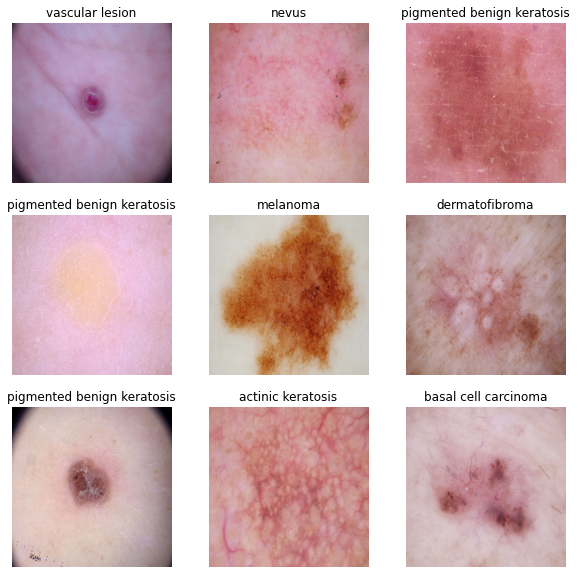

In [41]:
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [42]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [43]:
train_ds.cache()

<CacheDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [44]:
train_ds.prefetch(1)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
### Your code goes here

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Standardize the data

In [47]:
num_classes = 9

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [48]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [49]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 175s 706ms/step - loss: 1.9652 - accuracy: 0.2812 - val_loss: 1.7298 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6784 - accuracy: 0.3834 - val_loss: 1.6939 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5635 - accuracy: 0.4492 - val_loss: 1.4730 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.4484 - accuracy: 0.4894 - val_loss: 1.4587 - val_accuracy: 0.5145
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3458 - accuracy: 0.5296 - val_loss: 1.4042 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2815 - accuracy: 0.5485 - val_loss: 1.4392 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2097 - accuracy: 0.5692 - val_loss: 1.4893 - val_accuracy: 0.5056
Epoch 8/20

In [50]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 64)       

### Visualizing training results

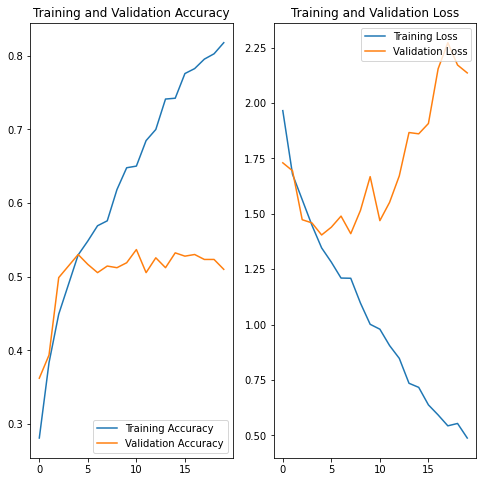

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### <font color='blue'> We have skin cancer images data with total 9 classes.
#### <font color='blue'> Original images pixel has range of [0,255]. so we normalise the data and bring the range of [0,1] to fit our nerual network model.
#### <font color='blue'> An input network that takes in images of dimension 180 by 180 by 3, with a ReLU activation function.
#### <font color='blue'> started with 2-dimensional convolution layer with 16 filters, where each filter size is 3x3.
#### <font color='blue'> continued convolutions with 32, 64, and 128 lasyers by Maxpoolong at each layer.
#### <font color='blue'> The output is layer of 9.
#### <font color='blue'> compared accuracy, and loss from both training and validation sets. noticed an evidence of mode overfitting.
#### <font color='blue'> to solve this problem, we will preprocess the images by rotating, cropping, translating, and zooming randomly.
#### <font color='blue'> we will also try drop out method, and augment the class imbalances.

In [52]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

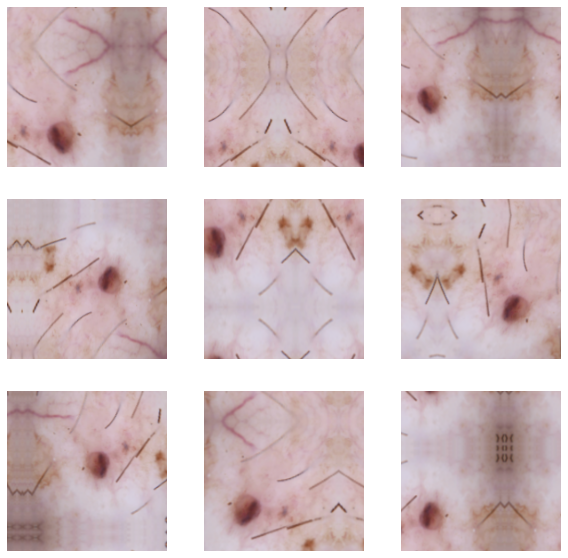

In [53]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [54]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    layers.Dropout(0.1),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    layers.Dropout(0.1),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])



### Compiling the model

In [55]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [56]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 33s 435ms/step - loss: 2.2605 - accuracy: 0.2338 - val_loss: 1.9311 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 23s 408ms/step - loss: 1.8794 - accuracy: 0.2818 - val_loss: 1.7780 - val_accuracy: 0.3154
Epoch 3/20
56/56 [==============================] - 24s 432ms/step - loss: 1.7205 - accuracy: 0.3426 - val_loss: 1.7169 - val_accuracy: 0.3445
Epoch 4/20
56/56 [==============================] - 24s 435ms/step - loss: 1.6849 - accuracy: 0.3744 - val_loss: 1.6586 - val_accuracy: 0.3781
Epoch 5/20
56/56 [==============================] - 24s 435ms/step - loss: 1.6992 - accuracy: 0.3521 - val_loss: 1.6436 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 24s 436ms/step - loss: 1.6078 - accuracy: 0.3856 - val_loss: 1.5997 - val_accuracy: 0.4251
Epoch 7/20
56/56 [==============================] - 24s 424ms/step - loss: 1.5683 - accuracy: 0.4241 - val_loss: 1.6294 - val_accuracy: 0.3870
Epoch 8/20

### Visualizing the results

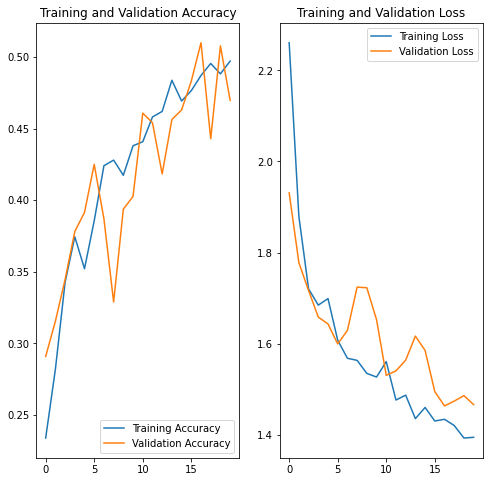

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### <font color='blue'> Applied random changes augmentaiton method on images.
### <font color='blue'> this time dropped 16 layer convolutions, and added 128 layer convolution.
### <font color='blue'> the accuracy comparision between Train and Test data shows neither underfitting nor overfitting. However the maximum accuracy reached up to 0.46 which is indicates the model needs further improvement.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)


2239

In [ ]:

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,melanoma


Class=0, n=114 (5.092%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)


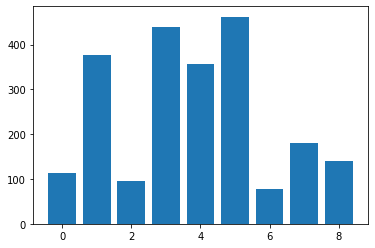

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [ ]:
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
### <font color = 'blue'> Class 6 (seborrheic keratosis) has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
### <font color = 'blue'> Classes [1,3,4,5] domates the data with each class above 15%.



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) #adding 500 sample to cure the class imabalances

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2831E2A610>: 100%|██████████| 500/500 [00:27<00:00, 18.20 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28D4253F70>: 100%|██████████| 500/500 [00:22<00:00, 21.78 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2836958520>: 100%|██████████| 500/500 [00:21<00:00, 23.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x7F2839A77460>: 100%|██████████| 500/500 [01:41<00:00,  4.92 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F28460D9790>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2839F924F0>: 100%|██████████| 500/500 [00:20<00:00, 24.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F28C0239490>: 100%|██████████| 500/500 [00:47<00:00, 10.43 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2839CD90A0>: 100%|██████████| 500/500 [00:19<00:00, 25.13 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2839A6FBE0>: 100%|██████████| 500/500 [00:19<00:00, 25.46 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [9]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [10]:
#data_dir_train="path to directory with training data + data created using augmentor"

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [12]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 9

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [14]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [15]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 244s 1s/step - loss: 1.7470 - accuracy: 0.3272 - val_loss: 1.4169 - val_accuracy: 0.4543
Epoch 2/30
169/169 [==============================] - 194s 1s/step - loss: 1.3515 - accuracy: 0.4900 - val_loss: 1.1994 - val_accuracy: 0.5531
Epoch 3/30
169/169 [==============================] - 185s 1s/step - loss: 1.1239 - accuracy: 0.5937 - val_loss: 1.1117 - val_accuracy: 0.5865
Epoch 4/30
169/169 [==============================] - 198s 1s/step - loss: 0.9447 - accuracy: 0.6563 - val_loss: 1.0865 - val_accuracy: 0.6221
Epoch 5/30
169/169 [==============================] - 197s 1s/step - loss: 0.7920 - accuracy: 0.7051 - val_loss: 0.9349 - val_accuracy: 0.6719
Epoch 6/30
169/169 [==============================] - 195s 1s/step - loss: 0.6220 - accuracy: 0.7791 - val_loss: 0.8868 - val_accuracy: 0.7053
Epoch 7/30
169/169 [==============================] - 190s 1s/step - loss: 0.5616 - accuracy: 0.8004 - val_loss: 0.8545 - val_accuracy: 0.6964

#### **Todo:**  Visualize the model results

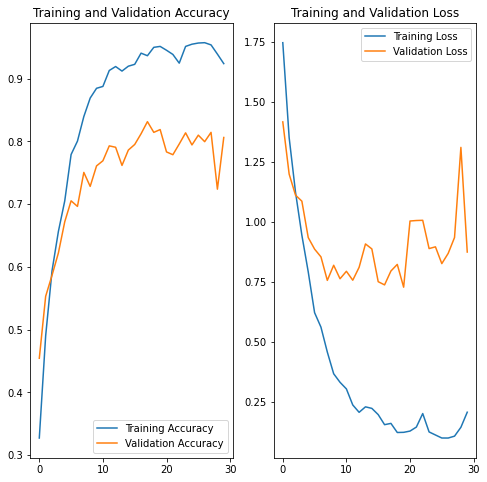

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### <font color = 'blue'> after balancing the classes by adding 500 samples to each class, the model performed better.
### <font color = 'blue'> However after 20 epochs there is no further  improvement noticed. 20 epochs should be enough for the model
